### Step 4. 위 3단계에서 분석한 결과를 기반으로 딥러닝용 데이터셋으로 재구성하는 파이썬 소스 코드
###### 제출된 파일에는 아래의 내용이 포함되어야 합니다.
1) pandas, matplotlib 등과 같은 라이브러리를 사용하여 딥러닝을 위해 데이터 처리(정제 및 가공 등)를 수행한 소스 코드
2) 소스 코드를 이해하기 쉽게 작성한 Markdown을 이용한 주석문

### 데이터 정제, 가공
해당 과정은 step 3에서 했던 정제 과정을 진행하는 코드입니다. 트레이닝 데이터와 테스트 데이터를 만들 때 사용하기 쉽도록 csv파일을 받아오는 리스트의 구조를 변경하였습니다. 또한 불용어 목록은 step 3 과정에서 추천받은 불용어를 넣었습니다.

1) 줄바꿈 제거                            
2) 한글 단어가 아닌 단어 제거
3) 빈 문자열 확인 및 제거
4) 불용어 지우기
5) 중복 제거
6) 데이터 개수 맞추기
7) 토큰화
8) 정수 인코딩
9) 희귀 단어 제거
10) 패딩

In [1]:
import csv 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

stopwords = ['사랑', '우리', '마음'] # step 3에서 추천된 불용어
csvs = ["발라드", "랩힙합", "트로트", "CCM"]

def csv_data(lists) :
    result = [[] for i in range(len(lists))]
    f = open('2_Origin Dataset.csv','r', encoding='utf-8')
    rdr = csv.reader(f)
    for line in rdr:
        if line[-1] == 'genre' : continue
        result[int(csvs.index(line[-1]))].append(line[2])
    f.close()
    for i, p in enumerate(result) :
        print(csvs[i], ":", len(p))
    return result

def replace_1(lists) : # '\n'제거
    result = []
    for l in lists :
        c = []
        for v in l :
            c.append(v.replace("\n", " "))
        result.append(c)
    return result

def replace_2(lists) : # 한글 빼고 모두 제거
    result = []
    for l in lists :
        c = []
        for v in l :
            c.append(re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]',"", v))
        result.append(c)
    return result

def del_null(lists) : # 빈 문자열 제거
    result = []
    for li in lists :
        array = []
        res = []
        for l in li :
            res.append(l)
            array.append(l.replace(' ', ''))
        delete_ly = [i for i, sentence in enumerate(array) if len(sentence) < 1]
        for l in delete_ly[::-1] :
            res.pop(l)
        result.append(res)
        
    lens = []
    for l in result :
        lens.append(len(l))
    range_c = min(lens)
    for i, p in enumerate(result) :
        print(csvs[i], ":", len(p))
    return result, range_c

def del_stopword(lists, stopwords) : # 불용어 제거
    result = []
    for l in lists :
        c = []
        for v in l :
            for word in stopwords :
                v = v.replace(word, "")
            c.append(v)
        result.append(c)
    return result

def del_repetition(lists) : # 같은 장르 내에서 중복 제거
    # 다른 장르에서 겹치는 곡이 있어도 이는 없애지 않는 것이 좋다고 판단하였습니다.
    origin_len = 0
    lists_2 = [] # 같은 장르 내 중복 제거 완료된 리스트
    for l in lists :
        origin_len += len(l)
        changed_list = []
        for v in l :
            if v not in changed_list :
                changed_list.append(v)
        lists_2.append(changed_list)
        
    changed_len = 0
    for l in lists_2 :
        changed_len += len(l)
    print(str(origin_len - changed_len) + "개의 곡을 제거하였습니다.")
    return lists_2
    

csv_data() 함수는 csv파일을 리스트로 받아오는 함수입니다. 아래에서 해당 함수를 받아온 data_b의 형태는 [[발라드 노래 가사],[랩힙합 노래 가사],[트로트 노래 가사],[CCM 노래 가사]]입니다.

In [2]:
data_b = csv_data(csvs)

발라드 : 1493
랩힙합 : 1325
트로트 : 1542
CCM : 1449


replace_1() 함수는 가사에서 "\n"를 제거해주는 함수입니다. 아래에서 data_c의 구조 자체는 data_b와 동일하지만 가사에서 "\n"이 제거됩니다.

In [3]:
data_c = replace_1(data_b)

replace_2() 함수는 가사에서 한글을 제외한 특수문자, 영어 등을 제거하는 함수입니다. 아래의 data_d는 위와 마찬가지로 data_b와 동일한 구조를 가지지만 특수문자, 영어가 제외된 가사가 들어있는 리스트입니다.

In [4]:
data_d = replace_2(data_c)

del_stopword() 함수는 가사에서 불용어를 제거하는 함수입니다. data_e 또한 마찬가지로 이전 data_d와 구조는 같고 가사에서 불용어가 빠진 형태입니다.

In [5]:
data_e = del_stopword(data_d, stopwords)

del_repetition() 함수는 같은 장르 내에서 겹치는 곡이 있다면 제거하는 함수입니다.

In [6]:
data_f = del_repetition(data_e)

439개의 곡을 제거하였습니다.


del_null() 함수는 위 두개의 정제 과정을 거친 후 사라진 가사를 탐지하여 제거하는 함수입니다. data_e의 값에서 공백 데이터가 제거되었습니다. (올바르게 지워졌습니다.) range_c는 각 장르의 곡의 수 중 가장 작은 값을 받습니다. 이 값은 이후 데이터의 개수를 일정하게 맞추는데 이용됩니다.

In [7]:
data_g, range_c = del_null(data_f)
print("-----------------")
print("최소길이 :", range_c)

발라드 : 1451
랩힙합 : 1288
트로트 : 1526
CCM : 1005
-----------------
최소길이 : 1005


#### 데이터 개수 맞추기
장르별 데이터 수의 차이는 학습시킬때 편향적으로 학습하는데 영향을 줄 수 있다고 생각했습니다. 아래 내용은 이러한 데이터의 수를 일정하게 맞추는 과정을 작성한 것입니다.

In [8]:
# 데이터 수 그래프 그리는 함수
def number_of_genre(lists) :
    font_location="c:/windows/fonts/HMFMMUEX.TTC" 
    font_name=fm.FontProperties(fname=font_location).get_name()
    matplotlib.rc('font',family=font_name)
    plt.figure(figsize=(6,3))
    plt.xlabel('장르')
    plt.ylabel('음악 수')
    len_list = []
    for i in lists :
        len_list.append(len(i))
    plt.ylim(min(len_list)-200, max(len_list)+50)
    plt.title('장르에 따른 데이터 개수')
    plt.bar(csvs, [len(i) for i in lists])
    plt.show()

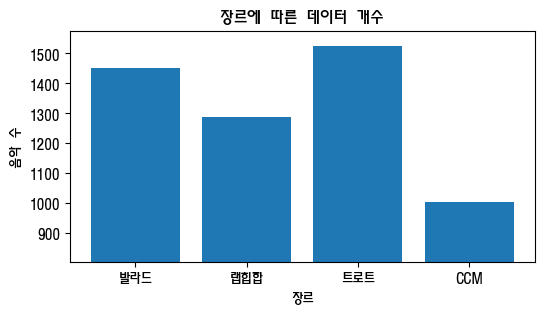

In [9]:
# 개수 제한을 하기 전 데이터
number_of_genre(data_g)

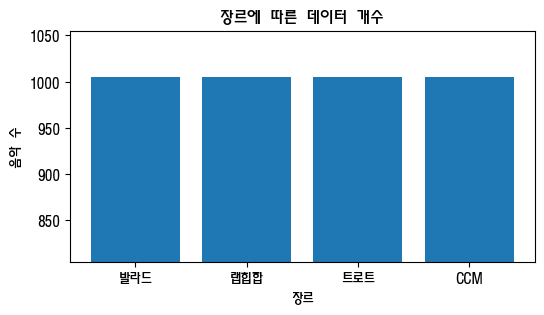

In [10]:
# 개수 제한을 한 이후 데이터
x_data = []
for line in data_g :
    x_data.append(line[:range_c])
number_of_genre(x_data)

#### 토큰화

In [13]:
# 토큰화와 레이블 마다 나누어져 있던 데이터 합치기, 
# 트레이닝 데이터와 테스트 데이터 나누기 과정을 수행하는 함수입니다.
# n으로는 트레이닝 데이터의 수, mode로는 이 함수를 이용해 얻을 값이 'train'인지 'test'인지 확인하는 인자입니다.
okt = Okt()
def get_okt(lists, n, mode) :
    pp = []
    pp_test = []
    x_train = []
    x_test = []
    if mode == "train" :
        for i, l in enumerate(lists) :
            for sentence in l[:n]:
                tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
                pp.append((tokenized_sentence, i))
                x_train.append(tokenized_sentence)
        return x_train, pp
    elif mode == "test" :
        for i, l in enumerate(lists) :
            for sentence in l[n:]:
                tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
                pp_test.append((tokenized_sentence, i))
                x_test.append(tokenized_sentence)
        return x_test, pp_test
    else :
        print("잘못된 mode 입력")
        return 0

아래에서 x_train과 x_test 값은 가사가 들어있는 1차원 배열이고, pp와 pp_test는 (가사, 레이블) 값이 들어있는 1차원 배열 값입니다. 레이블은 다음과 같이 대응됩니다.
1) 발라드 - 0
2) 랩힙합 - 1
3) 트로트 - 2
4) CCM    - 3

In [14]:
X_train, pp = get_okt(x_data, int(range_c*0.8), "train")
X_test, pp_test = get_okt(x_data, int(range_c*0.8), "test")

In [15]:
print("[토큰화된 데이터 예시]")
print(X_train[0])

[토큰화된 데이터 예시]
['늦다', '밤', '내', '품', '에', '안기다', '네', '가', '기억나다', '차다', '따스하다', '차다', '놀랍다', '이', '젠', '없다', '조금', '은', '궁금하다', '나', '없다', '하루', '에', '내', '흔적', '남다', '아직', '난', '너', '없다', '세상', '에', '남아', '서', '바보', '처럼', '살', '고', '있다', '괜찮다', '보', '여서', '미우다', '밤', '슬프다', '밤', '너', '때문', '에', '너무', '아프다', '넌', '아니다', '보다', '혼자', '하다', '이별', '이라', '그', '런가', '보다', '날', '보다', '미소', '를', '지다', '네', '가', '자꾸', '보고', '싶다', '밤', '영화', '처럼', '널', '마주치다', '다면', '고맙다', '미안하다', '말', '해주다', '솔직하다', '말', '하다', '혼자', '인', '시간', '은', '아직도', '무섭다', '오늘', '도', '너', '없다', '세상', '에', '버려진', '사람', '처럼', '살', '고', '있다', '괜찮다', '보', '여서', '미우다', '밤', '슬프다', '밤', '너', '때문', '에', '너무', '아프다', '넌', '아니다', '보다', '혼자', '하다', '이별', '이라', '그', '런가', '보다', '날', '보다', '미소', '를', '지다', '네', '가', '자꾸', '보고', '싶다', '밤', '영화', '처럼', '널', '마주치다', '다면', '고맙다', '미안하다', '말', '해주다', '우린', '힘들다', '하다', '우린', '허무하다', '이별', '을', '맞다', '너', '를', '생각', '하고', '나르다', '생각', '하다', '멈추다', '한다는', '걸', '눈물', '이', '차오르다', '미우다', '밤',

In [16]:
# 데이터 수 확인
def check_data(train, test) :
    print("train 데이터 수 :", len(train))
    tt = [0 for i in range(len(csvs))]
    for i in range(len(tt)) :
        for p in pp:
            if p[1] == 0:
                tt[i] += 1
    for i, c in enumerate(csvs) :
        print(c + " :", tt[i])

    print("--------------------------------")
    print("test 데이터 수 :", len(test))
    tt = [0 for i in range(len(csvs))]
    for i in range(len(tt)) :
        for p in pp_test:
            if p[1] == 0:
                tt[i] += 1
    for i, c in enumerate(csvs) :
        print(c + " :", tt[i])

check_data(X_train, X_test)

train 데이터 수 : 3216
발라드 : 804
랩힙합 : 804
트로트 : 804
CCM : 804
--------------------------------
test 데이터 수 : 804
발라드 : 201
랩힙합 : 201
트로트 : 201
CCM : 201


#### 데이터 구성

In [53]:
x_train = []
y_train = []
x_test = []
y_test = []
for a in pp :
    x_train.append(a[0])
    y_train.append(a[1])
for a in pp_test :
    x_test.append(a[0])
    y_test.append(a[1])
    
# 데이터 확인
print("train 데이터(x) :", len(x_train))
print("train 데이터(y) :", len(y_train))
print("test 데이터(x) :", len(x_test))
print("test 데이터(y) :", len(y_test))

train 데이터(x) : 3216
train 데이터(y) : 3216
test 데이터(x) : 804
test 데이터(y) : 804


#### 정수 인코딩
이때 빈도수가 너무 낮은 단어들은 제외하는 과정을 거치도록 했습니다.

In [54]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_num = len(tokenizer.word_index)
word_tot_num = 0
k = 0
rare_num = 0 
rare_tot_num = 0

for word, num in tokenizer.word_counts.items():
    word_tot_num = word_tot_num + num
    if(num < 3): # 빈도수가 3 이하인 단어를 희귀 단어로 설정
        rare_num = rare_num + 1
        rare_tot_num = rare_tot_num + num
print('전체 단어 수 : ' + str(word_num) + ', 희귀 단어 수 : ' + str(rare_num))
print("단순 희귀 단어 비율 :", (rare_num / word_num)*100, "%")
print("희귀 단어 등장 비율 :", (rare_tot_num/word_tot_num)*100, "%")

changed_word = word_num - rare_num + 1
# 새롭게 토크나이저
tokenizer = Tokenizer(num_words = changed_word)
tokenizer.fit_on_texts(x_train)

전체 단어 수 : 14663, 희귀 단어 수 : 7249
단순 희귀 단어 비율 : 49.437359339834956 %
희귀 단어 등장 비율 : 1.6536743452745906 %


In [55]:
tokenizer = Tokenizer(changed_word)
tokenizer.fit_on_texts(x_train)
print(tokenizer.word_index)

{'하다': 1, '이': 2, '을': 3, '에': 4, '내': 5, '의': 6, '나': 7, '가': 8, '너': 9, '은': 10, '는': 11, '를': 12, '그': 13, '없다': 14, '있다': 15, '도': 16, '보다': 17, '난': 18, '들': 19, '날': 20, '다': 21, '않다': 22, '것': 23, '말': 24, '주님': 25, '네': 26, '만': 27, '주': 28, '수': 29, '되다': 30, '못': 31, '로': 32, '나르다': 33, '더': 34, '가다': 35, '아': 36, '으로': 37, '해': 38, '안': 39, '때': 40, '같다': 41, '그대': 42, '오다': 43, '게': 44, '당신': 45, '내다': 46, '한': 47, '에서': 48, '사람': 49, '다시': 50, '모든': 51, '속': 52, '처럼': 53, '버리다': 54, '좋다': 55, '그렇다': 56, '이제': 57, '또': 58, '세상': 59, '와': 60, '널': 61, '과': 62, '함께': 63, '싶다': 64, '아니다': 65, '시간': 66, '고': 67, '돼다': 68, '밤': 69, '들다': 70, '모르다': 71, '알다': 72, '맘': 73, '생각': 74, '오늘': 75, '길': 76, '걸': 77, '에게': 78, '눈': 79, '예수': 80, '이다': 81, '곳': 82, '니': 83, '나다': 84, '지금': 85, '하나님': 86, '넌': 87, '야': 88, '잊다': 89, '서': 90, '손': 91, '주다': 92, '위': 93, '주의': 94, '기억': 95, '인생': 96, '라': 97, '요': 98, '살다': 99, '너무': 100, '까지': 101, '알': 102, '하나': 103, '삶': 104, '엔': 105, '

정수 인코딩 및 패딩을 하기 전, 신경망에 넣은 데이터의 길이를 정해주어야합니다. 저는 80% 이상의 데이터가 완전히 보존될 수 있는 데이터 길이를 찾고싶었습니다.

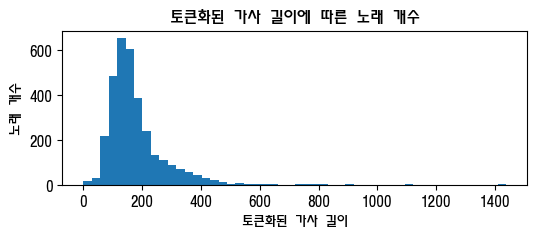

길이가 200 이하인 곡의 비율: 73.10323383084577%
길이가 250 이하인 곡의 비율: 84.26616915422885%
길이가 300 이하인 곡의 비율: 90.36069651741293%


In [56]:
def check_len_below_percent(len_val, lists): 
    # 가사 길이가 len_val 이하인 비율 출력
    count = 0
    for l in lists:
        if(len(l) <= len_val):
            count = count + 1
    print('길이가 '+str(len_val)+' 이하인 곡의 비율: ' + str((count / len(lists))*100) + "%")

plt.figure(figsize=(6,2))
plt.title('토큰화된 가사 길이에 따른 노래 개수')
plt.xlabel('토큰화된 가사 길이')
plt.ylabel('노래 개수')
plt.hist([len(review) for review in x_train], bins=50)
plt.show()   
    
    
    
check_len_below_percent(200, x_train)
check_len_below_percent(250, x_train)    
check_len_below_percent(300, x_train)

In [57]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)  
max_len = 250 # 위에서 250일 때 80% 이상의 가사를 모두 표현할 수 있다고 확인했습니다
x_test = pad_sequences(x_test, maxlen=max_len) #  길이보다 짧은 가사는 패딩해줍니다
x_train = pad_sequences(x_train, maxlen=max_len)

In [60]:
print("[정수 인코딩된 데이터 예시]")
print(x_train[0])

[정수 인코딩된 데이터 예시]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0  417   69    5
  339    4  664   26    8 1636  208  651  208  906    2  119   14  277
   10 1138    7   14  120    4    5  622  163  165   18    9   14   59
    4  483   90  357   53  132   67   15  233  757 1241  707   69  315
   69    9  334    4  100  109   87   65   17  196    1  291  296   13
 3202   17   20   17  336   12  206   26    8  380  175   64   69  915
   53   61  748 4912  434  354   24  159  786   24    1  196  173   66
   10  359  766   75   16    9   14   59    4 2687   49   53  132   67
   15  233  757 1241  707   69  315   69    9  334    4  100  109   87
   65   17  196    1  291  296   13 3202   17   20   17  336   12  206
   26    8  380  175   64   69  915   53   61  748 4912  434

### 데이터 저장
위에서 정제 및 가공한 데이터를 엑셀로 저장할 것입니다. 가사와 그에 따른 레이블 값을 저장할 것입니다.

아래에서 만든 파일에는 토큰화 및 정수 인코딩 된 데이터의 각 자리(250자)의 숫자가 들어갑니다. 또한 장르와, train 인지 test 인지 알아볼 수 있도록 추가하였습니다. 

In [62]:
file_name = "4_Refined Dataset.csv"
refined_data = pd.DataFrame()
label_val = []
learing_type = ['train' for k in x_train] + ['test' for k in x_test]
for i in range(len(x_train[0])) :
    refined_data[str(i+1)+"th value"] = [l[i] for l in x_train] + [l[i] for l in x_test]
for i in range(len(csvs)) :
    label_val += [i for k in range(int(len(x_train)/len(csvs)))]
for i in range(len(csvs)) :
    label_val += [i for k in range(int(len(x_test)/len(csvs)))]
refined_data["genre"] = label_val
refined_data["type"] = learing_type
refined_data.to_csv(file_name, encoding='utf-8-sig')